In [1]:
%matplotlib inline
%pylab inline

from functools import partial
import  matplotlib.pyplot as plt

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift
from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

from menpofit.result import compute_normalise_point_to_point_error, compute_cumulative_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import SSDAsymmetricGaussNewtonSimultaneous
from menpofit.visualize import visualize_fitting_result, plot_ced, print_progress

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

In [3]:
image_folder = '/Users/joan/PhD/DataBases/faces/'
model_folder = '/Users/joan/PhD/Papers/alabort_arxiv2015_aam/experiments/'
result_folder = model_folder + 'sampling/'

## Load AAM

In [4]:
aam = mio.import_pickle(model_folder + 'aam.pkl.gz')

## Load test data

In [6]:
test_images = []
for i in mio.import_images(image_folder + 'lfpw/testset/', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


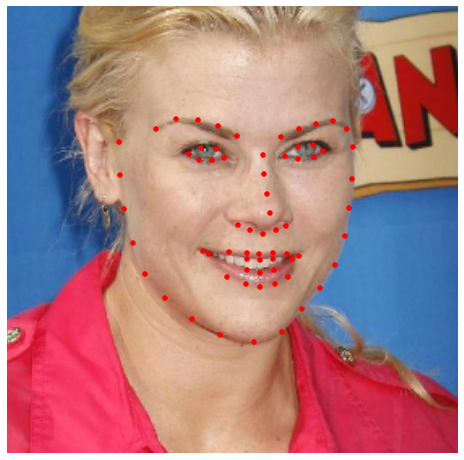

In [7]:
visualize_images(test_images)

## Fit AAM

In [8]:
n_shape = [3, 12]
n_appearance = 0.75
max_iters = [24, 16]
noise_percentages = np.arange(0, 0.125, 0.025)

repeat = 3

#### Sampled AAM Fitters

In [9]:
sampling_scales = [0.125, 0.25, 0.5, 1.0]

fitters = []
for scale in sampling_scales:
    
    sampling_step_1, _ = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                      scale=np.minimum(2 * scale, 1))
    sampling_step_2, _ = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)
    
    sampling_step = [sampling_step_1, sampling_step_2]

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(SSDAsymmetricGaussNewtonSimultaneous), 
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters.append(fitter)

In [10]:
n_fitters = len(fitters)
legend_entries = ['Initialization'] + ['{:.0f}%'.format(100*scale) for scale in sampling_scales]

#### Fitting loop

In [11]:
fitters_results =[]
for noise_percentage in noise_percentages:
    
    print '- Noise Percentage: {}'.format(noise_percentage)
    
    frs = []
    for j, image in enumerate(repeat * test_images):

        np.random.seed(j)

        gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
        initial_shape = fitters[0].noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, 
                                                          rotation=True)

        for fitter in fitters:

            fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
            fr.downscale = 0.5
            frs.append(fr.as_serializableresult())

            print_dynamic(
                'Image: {} - Initial error: {} - Final error: {}'
                .format(j, fr.initial_error(), fr.final_error()))
    
    fitters_results.append(frs)

- Noise Percentage: 0.0
- Noise Percentage: 0.025
- Noise Percentage: 0.05
- Noise Percentage: 0.075
- Noise Percentage: 0.1


## Results

Save fitters results:

In [12]:
# mio.export_pickle(fitters_results, result_folder + 'ssd_asym_gn.pkl.gz')

In [5]:
# fitters_results = mio.import_pickle(result_folder + 'ssd_asym_gn.pkl.gz')

# sampling_scales = [0.125, 0.25, 0.5, 1.0]
# n_fitters = 4
# legend_entries = ['Initialization'] + ['{:.0f}%'.format(100*scale) for scale in sampling_scales]
# max_iters = [24, 16]

Produce combined mean error vs standard deviation graph:

In [6]:
mean_errors = []
std_errors = []
median_errors = []
convergence_errors = []

for frs in fitters_results:

    errors = []
    conv_errors = []
    for j in range(n_fitters):
        errors_j = []
        for fr in frs[j::n_fitters]:
            error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                           fr.gt_shape.points[17:, :],
                                                           norm_shape=fr.gt_shape.points)
            errors_j.append(error)
        errors.append(errors_j)
        
        conv_errors.append(compute_cumulative_error(errors_j, np.asarray([0.02, 0.03, 0.04])))

    mean_errs = []
    std_errs = []
    median_errs = []
    for j in range(n_fitters):
        errs = np.asarray(errors[j])
        mean_errs.append(np.mean(errs))
        std_errs.append(np.std(errs))
        median_errs.append(np.median(errs))
    
    mean_errors.append(mean_errs)
    std_errors.append(std_errs)
    median_errors.append(median_errs)
    
    convergence_errors.append(conv_errors)
    
mean_errors_matrix = np.asarray(mean_errors).T
std_errors_matrix = np.asarray(std_errors).T
median_errors_matrix = np.asarray(median_errors).T
convergence_errors_matrix = np.asarray(convergence_errors).T

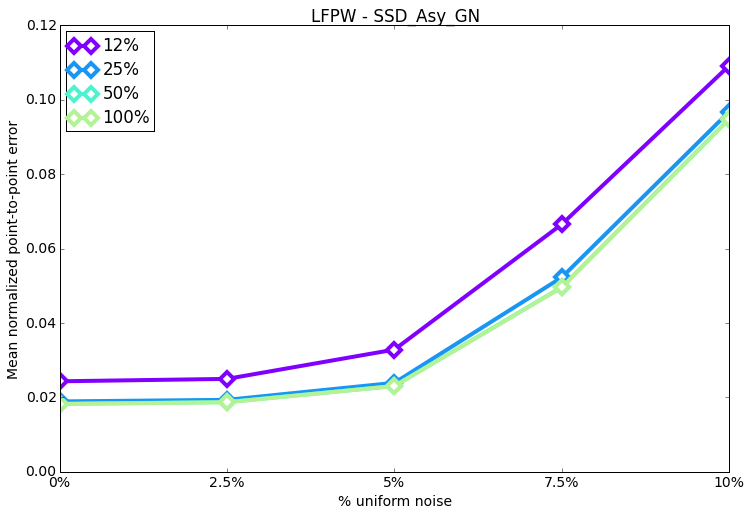

In [7]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(5, 'rainbow')

fig = plt.figure()
plt.hold(True)

for i in range(mean_errors_matrix.shape[0]):
    plt.plot(np.arange(0, len(mean_errors_matrix[i, :])), 
             mean_errors_matrix[i, :],
             color=colours[i],
             linewidth=4,
             marker='D',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('% uniform noise')
plt.ylabel('Mean normalized point-to-point error')
plt.xlim((0, 1))
#plt.ylim((0.01, 0.04))

width = mean_errors_matrix.shape[1]
x_axis_labels = ['0%', '2.5%', '5%', '7.5%', '10%']
plt.xticks(range(width), x_axis_labels)

plt.legend(['12%', '25%', '50%', '100%'], loc=2)

plt.title('LFPW - SSD_Asy_GN')

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'mean_error_vs_noise_sampling_ssd_asy_gn_{}.png', 
            format='png', dpi=300,  bbox_inches='tight')

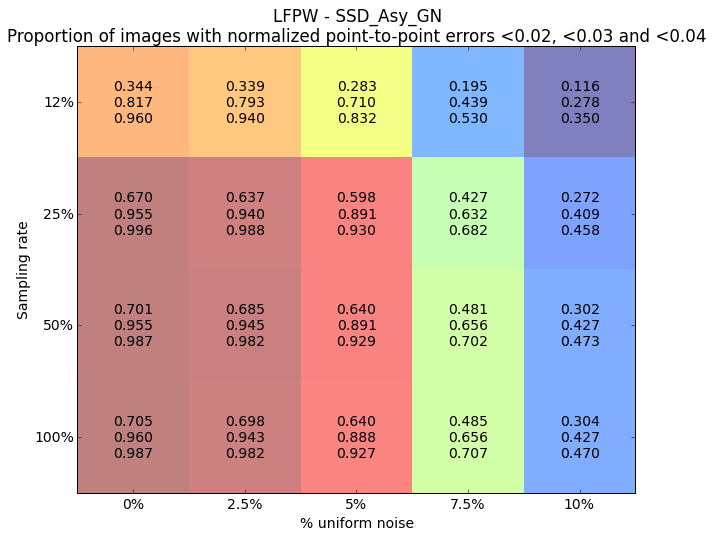

In [10]:
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(convergence_errors_matrix[1]), cmap=plt.cm.jet, 
                alpha=0.5, interpolation='nearest')

height, width = mean_errors_matrix.shape


for x in xrange(width):
    for y in xrange(height):
        ax.annotate("{:.3f}\n{:.3f}\n{:.3f}".format
                    (convergence_errors_matrix[0][y][x], 
                     convergence_errors_matrix[1][y][x], 
                     convergence_errors_matrix[2][y][x]), 
                    xy=(x, y), 
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='black')

# cb = fig.colorbar(res)
x_axis_labels = ['0%', '2.5%', '5%', '7.5%', '10%']
y_axis_labels = ['12%', '25%', '50%', '100%']
plt.xticks(range(width), x_axis_labels[:width])
plt.yticks(range(height), y_axis_labels[:height])
plt.xlabel('% uniform noise')
plt.ylabel('Sampling rate')

plt.title('LFPW - SSD_Asy_GN\nProportion of images with normalized point-to-point errors <0.02, <0.03 and <0.04')

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'sampling_vs_noise_ssd_asy_gn.png', 
            format='png', dpi=300, bbox_inches='tight')

Measure the speed of each fitter:

In [16]:
%timeit -n 10 fr = fitters[0].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitters[1].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitters[2].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
%timeit -n 10 fr = fitters[3].fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 

10 loops, best of 3: 596 ms per loop
10 loops, best of 3: 653 ms per loop
10 loops, best of 3: 930 ms per loop
10 loops, best of 3: 1.68 s per loop


## Other

In [ ]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 